# Time Series Modelling - Seasonal AutoRegressive Integrated Moving Average with Exogenous Variables (SARIMAX)

**Using CBroBERTa Sentiment Scores for Speeches between 2015-2024 to predict CPI rate**

## Section A

### Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import r2_score, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings("ignore")


### File import and lagged variables creation I

In [2]:
df = pd.read_csv("tsm_data.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.asfreq('MS')

# Create lag-1 versions of sentiment variables
df['cbroberta_avg_score_lag1'] = df['cbroberta_avg_score'].shift(1)
df['firms_lag1'] = df['firms'].shift(1)
df['central_bank_lag1'] = df['central_bank'].shift(1)
df['households_lag1'] = df['households'].shift(1)


### Seasonal Decomposition of CPI Rate

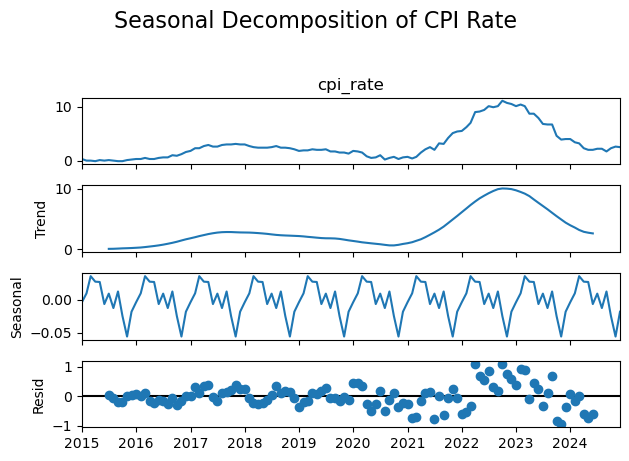

In [3]:
decomp = seasonal_decompose(df['cpi_rate'], model='additive')
fig = decomp.plot()
plt.suptitle('Seasonal Decomposition of CPI Rate', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


#### Commentary 1

- UK CPI inflation was stable/low pre-2021, then surged in 2022 - 2023 (peaking above 10%), and started to decline in 2024.
- This matches real world events: COVID-19 effects, supply chain shocks, energy crisis, etc.
- Most of the action is in the trend, not the seasonality (seasonal swings are minor) which is typical for inflation. 

### Functions for SARIMAX using auto_arima to determine statistically safe lags

In [4]:
def get_safe_lags(target, max_lag, order, seasonal_order):
    p, d, q = order
    P, D, Q, s = seasonal_order
    exclude = set(range(1, max(p, q)+1))
    for i in range(1, max(P, Q)+1):
        lag = i * s
        if lag <= max_lag:
            exclude.add(lag)
    included = [f"{target}_lag{lag}" for lag in range(1, max_lag+1) if lag not in exclude]
    return included

def fit_sarimax_comparison(
    df,
    target_col,
    exog_vars,
    max_lag=6,
    test_size=0.2,
    m=12
):
    df = df.copy()
    for lag in range(1, max_lag+1):
        df[f"{target_col}_lag{lag}"] = df[target_col].shift(lag)
    df_lags = df.dropna().copy()
    split_idx = int(len(df_lags) * (1 - test_size))
    train = df_lags.iloc[:split_idx]
    test = df_lags.iloc[split_idx:]
    safe_lags = get_safe_lags(target_col, max_lag, (1,2,2), (2,0,0,12))  # placeholder, will be updated below
    model_auto = auto_arima(
        train[target_col],
        exogenous=train[exog_vars],
        seasonal=True,
        m=m,
        trace=True,
        stepwise=True,
        error_action='ignore',
        suppress_warnings=True,
        max_p=3, max_q=3, max_P=2, max_Q=2,
        max_order=6,
        information_criterion='aic'
    )
    safe_lags = get_safe_lags(target_col, max_lag, model_auto.order, model_auto.seasonal_order)
    final_exog = exog_vars + safe_lags
    model = SARIMAX(
        train[target_col],
        exog=train[final_exog],
        order=model_auto.order,
        seasonal_order=model_auto.seasonal_order,
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    results = model.fit(disp=False)
    forecast = results.predict(start=test.index[0], end=test.index[-1], exog=test[final_exog])
    mae = mean_absolute_error(test[target_col], forecast)
    r2 = r2_score(test[target_col], forecast)
    return results, train, test, forecast, mae, r2, model_auto.order, model_auto.seasonal_order, final_exog


In [5]:
def plot_sarimax_results(train, test, forecast, target_col, model_label, mae, r2):
    plt.figure(figsize=(12, 4))
    plt.plot(train.index, train[target_col], label='Train', color='blue')
    plt.plot(test.index, test[target_col], label='Test Actual', color='black')
    plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--')
    plt.title(f'{model_label} | MAE={mae:.2f}  R²={r2:.2f}')
    plt.legend()
    plt.grid(True)
    plt.show()


### Predicting CPI rate using CBroBERTa Average Sentiment Score at t=0 and t=1 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=90.652, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=144.676, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=114.897, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=91.435, Time=0.05 sec
 ARIMA(2,2,2)(0,0,1)[12]             : AIC=90.654, Time=0.19 sec
 ARIMA(2,2,2)(1,0,0)[12]             : AIC=93.213, Time=0.17 sec
 ARIMA(2,2,2)(2,0,1)[12]             : AIC=90.453, Time=0.70 sec
 ARIMA(2,2,2)(2,0,0)[12]             : AIC=88.525, Time=0.67 sec
 ARIMA(1,2,2)(2,0,0)[12]             : AIC=87.700, Time=0.30 sec
 ARIMA(1,2,2)(1,0,0)[12]             : AIC=92.238, Time=0.07 sec
 ARIMA(1,2,2)(2,0,1)[12]             : AIC=89.448, Time=0.36 sec
 ARIMA(1,2,2)(1,0,1)[12]             : AIC=89.754, Time=0.15 sec
 ARIMA(0,2,2)(2,0,0)[12]             : AIC=91.472, Time=0.13 sec
 ARIMA(1,2,1)(2,0,0)[12]             : AIC=91.938, Time=0.17 sec
 ARIMA(1,2,3)(2,0,0)[12]             : AIC=95

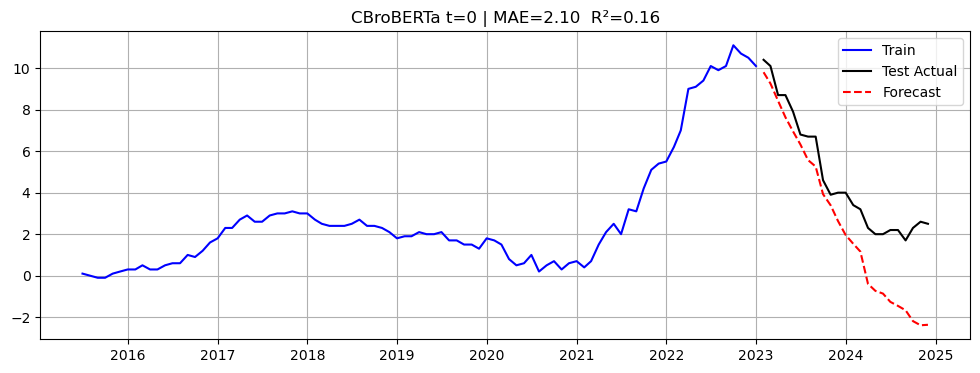

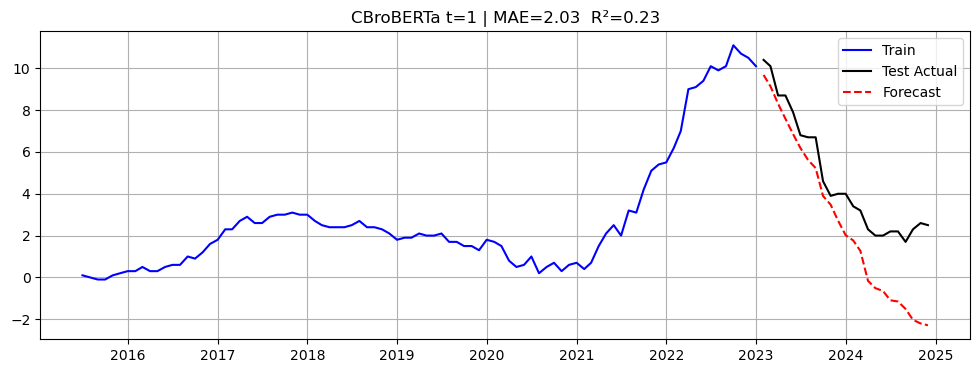

In [6]:
# t=0 (contemporaneous)
exog_cbrob_t0 = ['cbroberta_avg_score']
res_t0, tr_t0, te_t0, fc_t0, mae_t0, r2_t0, order_t0, seas_t0, exogvars_t0 = fit_sarimax_comparison(
    df, 'cpi_rate', exog_cbrob_t0)

# t=1 (lagged)
exog_cbrob_t1 = ['cbroberta_avg_score_lag1']
res_t1, tr_t1, te_t1, fc_t1, mae_t1, r2_t1, order_t1, seas_t1, exogvars_t1 = fit_sarimax_comparison(
    df, 'cpi_rate', exog_cbrob_t1)

print("CBroBERTa t=0  | MAE:", mae_t0, "R2:", r2_t0, "Order:", order_t0, "Seasonal:", seas_t0)
print("CBroBERTa t=1  | MAE:", mae_t1, "R2:", r2_t1, "Order:", order_t1, "Seasonal:", seas_t1)

plot_sarimax_results(tr_t0, te_t0, fc_t0, 'cpi_rate', "CBroBERTa t=0", mae_t0, r2_t0)
plot_sarimax_results(tr_t1, te_t1, fc_t1, 'cpi_rate', "CBroBERTa t=1", mae_t1, r2_t1)


### Predicting CPI rate using  CBroBERTa Economic Agent (firms, households, central_bank) at t=0 and t=1

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=90.652, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=144.676, Time=0.00 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=114.897, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=91.435, Time=0.05 sec
 ARIMA(2,2,2)(0,0,1)[12]             : AIC=90.654, Time=0.20 sec
 ARIMA(2,2,2)(1,0,0)[12]             : AIC=93.213, Time=0.21 sec
 ARIMA(2,2,2)(2,0,1)[12]             : AIC=90.453, Time=0.72 sec
 ARIMA(2,2,2)(2,0,0)[12]             : AIC=88.525, Time=0.55 sec
 ARIMA(1,2,2)(2,0,0)[12]             : AIC=87.700, Time=0.23 sec
 ARIMA(1,2,2)(1,0,0)[12]             : AIC=92.238, Time=0.09 sec
 ARIMA(1,2,2)(2,0,1)[12]             : AIC=89.448, Time=0.37 sec
 ARIMA(1,2,2)(1,0,1)[12]             : AIC=89.754, Time=0.13 sec
 ARIMA(0,2,2)(2,0,0)[12]             : AIC=91.472, Time=0.16 sec
 ARIMA(1,2,1)(2,0,0)[12]             : AIC=91.938, Time=0.16 sec
 ARIMA(1,2,3)(2,0,0)[12]             : AIC=95

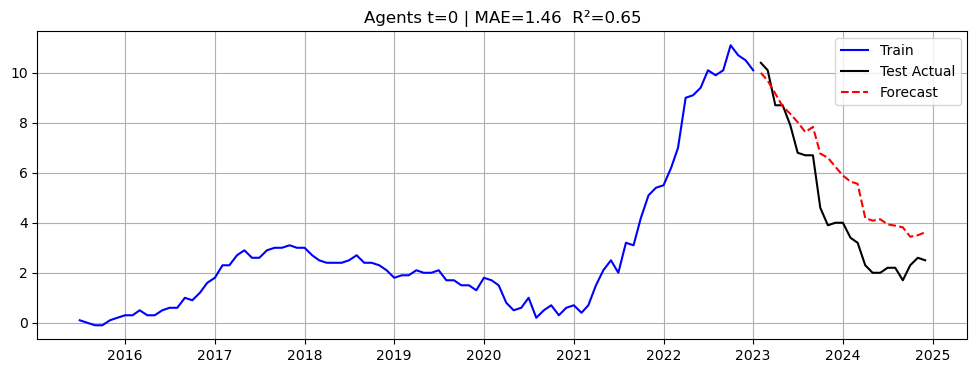

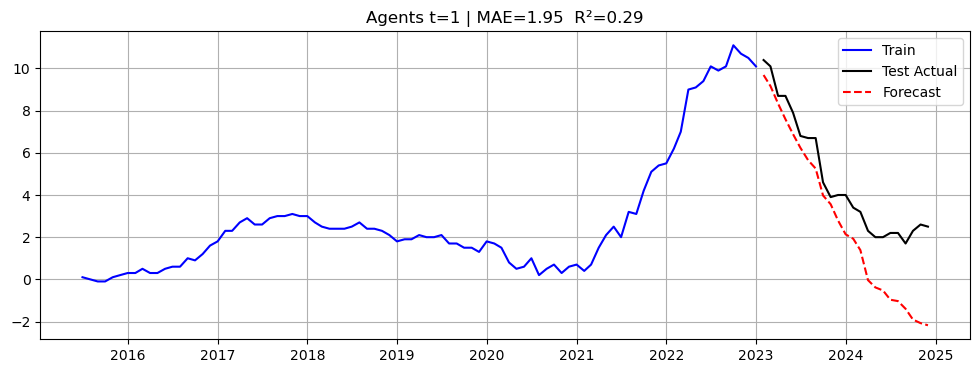

In [7]:
# t=0 (contemporaneous)
exog_agents_t0 = ['firms', 'central_bank', 'households']
res2_t0, tr2_t0, te2_t0, fc2_t0, mae2_t0, r2_2t0, order_2t0, seas_2t0, exogvars_2t0 = fit_sarimax_comparison(
    df, 'cpi_rate', exog_agents_t0)

# t=1 (lagged)
exog_agents_t1 = ['firms_lag1', 'central_bank_lag1', 'households_lag1']
res2_t1, tr2_t1, te2_t1, fc2_t1, mae2_t1, r2_2t1, order_2t1, seas_2t1, exogvars_2t1 = fit_sarimax_comparison(
    df, 'cpi_rate', exog_agents_t1)

print("Agents t=0     | MAE:", mae2_t0, "R2:", r2_2t0, "Order:", order_2t0, "Seasonal:", seas_2t0)
print("Agents t=1     | MAE:", mae2_t1, "R2:", r2_2t1, "Order:", order_2t1, "Seasonal:", seas_2t1)

plot_sarimax_results(tr2_t0, te2_t0, fc2_t0, 'cpi_rate', "Agents t=0", mae2_t0, r2_2t0)
plot_sarimax_results(tr2_t1, te2_t1, fc2_t1, 'cpi_rate', "Agents t=1", mae2_t1, r2_2t1)


In [8]:
results_df = pd.DataFrame({
    "Model": [
        "CBroBERTa t=0", "CBroBERTa t=1",
        "Agents t=0", "Agents t=1"
    ],
    "MAE": [mae_t0, mae_t1, mae2_t0, mae2_t1],
    "R2": [r2_t0, r2_t1, r2_2t0, r2_2t1],
    "Order": [order_t0, order_t1, order_2t0, order_2t1],
    "Seasonal": [seas_t0, seas_t1, seas_2t0, seas_2t1],
    "Exogenous": [exogvars_t0, exogvars_t1, exogvars_2t0, exogvars_2t1]
})
display(results_df)


,Model,MAE,R2,Order,Seasonal,Exogenous
0,CBroBERTa t=0,2.104208,0.163711,"(1, 2, 2)","(2, 0, 0, 12)","[cbroberta_avg_score, cpi_rate_lag3, cpi_rate_..."
1,CBroBERTa t=1,2.032560,0.234672,"(1, 2, 2)","(2, 0, 0, 12)","[cbroberta_avg_score_lag1, cpi_rate_lag3, cpi_..."
2,Agents t=0,1.456678,0.653921,"(1, 2, 2)","(2, 0, 0, 12)","[firms, central_bank, households, cpi_rate_lag..."
3,Agents t=1,1.948640,0.287863,"(1, 2, 2)","(2, 0, 0, 12)","[firms_lag1, central_bank_lag1, households_lag..."


In [9]:
def print_full_coeff_summary(results, exog_vars, model_label):
    params = results.params
    bse = results.bse
    pvalues = results.pvalues
    print(f"\n=== {model_label} ===")
    print(f"{'Variable':<25} {'Coef':>8} {'StdErr':>10} {'p-value':>10} {'Significant':>12}")
    print("-" * 65)
    for var in exog_vars:
        if var in params.index:
            coef = params[var]
            stderr = bse[var]
            pval = pvalues[var]
            signif = "Yes" if pval < 0.05 else ""
            print(f"{var:<25} {coef:>8.3f} {stderr:>10.3f} {pval:>10.4f} {signif:>12}")
    print("-" * 65)


In [10]:
print_full_coeff_summary(res_t0, exogvars_t0, "CBroBERTa t=0 (contemporaneous)")
print_full_coeff_summary(res_t1, exogvars_t1, "CBroBERTa t=1 (lagged 1)")
print_full_coeff_summary(res2_t0, exogvars_2t0, "Agents t=0 (contemporaneous)")
print_full_coeff_summary(res2_t1, exogvars_2t1, "Agents t=1 (lagged 1)")



=== CBroBERTa t=0 (contemporaneous) ===
Variable                      Coef     StdErr    p-value  Significant
-----------------------------------------------------------------
cbroberta_avg_score          0.321      0.145     0.0262          Yes
cpi_rate_lag3               -0.014      0.110     0.9002             
cpi_rate_lag4               -0.065      0.155     0.6741             
cpi_rate_lag5                0.018      0.112     0.8714             
cpi_rate_lag6                0.513      0.137     0.0002          Yes
-----------------------------------------------------------------

=== CBroBERTa t=1 (lagged 1) ===
Variable                      Coef     StdErr    p-value  Significant
-----------------------------------------------------------------
cbroberta_avg_score_lag1     0.055      0.163     0.7381             
cpi_rate_lag3               -0.038      0.115     0.7385             
cpi_rate_lag4               -0.065      0.162     0.6864             
cpi_rate_lag5              

#### Commentary 2

- Using CBroBERTa economic agent sentiment for households, firms and central bank yielded better results than using
  the CBroBERTa average sentiment score.
- In terms of the Agents model t=0 and t=1, contemporaneous speech sentiment provided more explantory power.
- cpi_rate_lag6 was statistically significant in all models.
- Crucially, for best-performing model Agents t=0, the coefficient for central_bank agent sentiment statistically significant.
  (coefficient: 0.385, p-value: 0.0237)

In [11]:
# Function as before
def extract_significant_vars(results, exog_vars, alpha=0.05):
    sig_vars = []
    for var in exog_vars:
        if var in results.pvalues and results.pvalues[var] < alpha:
            sig_vars.append(var)
    return sig_vars

# Extract for all models (assuming previous fits have been run)
sig_cbro_t0 = extract_significant_vars(res_t0, exogvars_t0)
sig_cbro_t1 = extract_significant_vars(res_t1, exogvars_t1)
sig_2t0     = extract_significant_vars(res2_t0, exogvars_2t0)
sig_2t1     = extract_significant_vars(res2_t1, exogvars_2t1)

print("CBroBERTa t=0 significant:", sig_cbro_t0)
print("CBroBERTa t=1 significant:", sig_cbro_t1)
print("Agents t=0 significant:", sig_2t0)
print("Agents t=1 significant:", sig_2t1)


CBroBERTa t=0 significant: ['cbroberta_avg_score', 'cpi_rate_lag6']
CBroBERTa t=1 significant: ['cpi_rate_lag6']
Agents t=0 significant: ['central_bank', 'cpi_rate_lag6']
Agents t=1 significant: ['cpi_rate_lag6']


In [12]:
# For each, only refit if there are significant variables
refitted_results = []

# CBroBERTa t=0
if len(sig_cbro_t0) > 0:
    res_t0_refit, tr_t0_refit, te_t0_refit, fc_t0_refit, mae_t0_refit, r2_t0_refit, order_t0_refit, seas_t0_refit, exogvars_t0_refit = \
        fit_sarimax_comparison(df, 'cpi_rate', sig_cbro_t0)
    refitted_results.append(("CBroBERTa t=0 (refit)", res_t0_refit, tr_t0_refit, te_t0_refit, fc_t0_refit, mae_t0_refit, r2_t0_refit, order_t0_refit, seas_t0_refit, exogvars_t0_refit))
else:
    refitted_results.append(("CBroBERTa t=0 (refit)", None, None, None, None, None, None, None, None, []))

# CBroBERTa t=1
if len(sig_cbro_t1) > 0:
    res_t1_refit, tr_t1_refit, te_t1_refit, fc_t1_refit, mae_t1_refit, r2_t1_refit, order_t1_refit, seas_t1_refit, exogvars_t1_refit = \
        fit_sarimax_comparison(df, 'cpi_rate', sig_cbro_t1)
    refitted_results.append(("CBroBERTa t=1 (refit)", res_t1_refit, tr_t1_refit, te_t1_refit, fc_t1_refit, mae_t1_refit, r2_t1_refit, order_t1_refit, seas_t1_refit, exogvars_t1_refit))
else:
    refitted_results.append(("CBroBERTa t=1 (refit)", None, None, None, None, None, None, None, None, []))

# Agents t=0
if len(sig_2t0) > 0:
    res2_t0_refit, tr2_t0_refit, te2_t0_refit, fc2_t0_refit, mae2_t0_refit, r2_2t0_refit, order_2t0_refit, seas_2t0_refit, exogvars_2t0_refit = \
        fit_sarimax_comparison(df, 'cpi_rate', sig_2t0)
    refitted_results.append(("Agents (firms, cb, hh) t=0 (refit)", res2_t0_refit, tr2_t0_refit, te2_t0_refit, fc2_t0_refit, mae2_t0_refit, r2_2t0_refit, order_2t0_refit, seas_2t0_refit, exogvars_2t0_refit))
else:
    refitted_results.append(("Agents (firms, cb, hh) t=0 (refit)", None, None, None, None, None, None, None, None, []))

# Agents t=1
if len(sig_2t1) > 0:
    res2_t1_refit, tr2_t1_refit, te2_t1_refit, fc2_t1_refit, mae2_t1_refit, r2_2t1_refit, order_2t1_refit, seas_2t1_refit, exogvars_2t1_refit = \
        fit_sarimax_comparison(df, 'cpi_rate', sig_2t1)
    refitted_results.append(("Agents (firms, cb, hh) t=1 (refit)", res2_t1_refit, tr2_t1_refit, te2_t1_refit, fc2_t1_refit, mae2_t1_refit, r2_2t1_refit, order_2t1_refit, seas_2t1_refit, exogvars_2t1_refit))
else:
    refitted_results.append(("Agents (firms, cb, hh) t=1 (refit)", None, None, None, None, None, None, None, None, []))


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=90.652, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=144.676, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=114.897, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=91.435, Time=0.07 sec
 ARIMA(2,2,2)(0,0,1)[12]             : AIC=90.654, Time=0.18 sec
 ARIMA(2,2,2)(1,0,0)[12]             : AIC=93.213, Time=0.16 sec
 ARIMA(2,2,2)(2,0,1)[12]             : AIC=90.453, Time=0.68 sec
 ARIMA(2,2,2)(2,0,0)[12]             : AIC=88.525, Time=0.59 sec
 ARIMA(1,2,2)(2,0,0)[12]             : AIC=87.700, Time=0.21 sec
 ARIMA(1,2,2)(1,0,0)[12]             : AIC=92.238, Time=0.09 sec
 ARIMA(1,2,2)(2,0,1)[12]             : AIC=89.448, Time=0.38 sec
 ARIMA(1,2,2)(1,0,1)[12]             : AIC=89.754, Time=0.61 sec
 ARIMA(0,2,2)(2,0,0)[12]             : AIC=91.472, Time=0.11 sec
 ARIMA(1,2,1)(2,0,0)[12]             : AIC=91.938, Time=0.19 sec
 ARIMA(1,2,3)(2,0,0)[12]             : AIC=95

In [13]:
comparison_all_refit = pd.DataFrame([
    {
        "Model": model_name,
        "MAE": mae,
        "R2": r2,
        "Order": order,
        "Seasonal": seas,
        "Significant_Features": exogvars
    }
    for (model_name, res, tr, te, fc, mae, r2, order, seas, exogvars) in refitted_results
])
pd.set_option('display.max_colwidth', 500)
display(comparison_all_refit)


,Model,MAE,R2,Order,Seasonal,Significant_Features
0,CBroBERTa t=0 (refit),2.106887,0.161716,"(1, 2, 2)","(2, 0, 0, 12)","[cbroberta_avg_score, cpi_rate_lag6, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
1,CBroBERTa t=1 (refit),2.061925,0.210591,"(1, 2, 2)","(2, 0, 0, 12)","[cpi_rate_lag6, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
2,"Agents (firms, cb, hh) t=0 (refit)",1.872746,0.433226,"(1, 2, 2)","(2, 0, 0, 12)","[central_bank, cpi_rate_lag6, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
3,"Agents (firms, cb, hh) t=1 (refit)",2.061925,0.210591,"(1, 2, 2)","(2, 0, 0, 12)","[cpi_rate_lag6, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"


In [14]:
compare_models_df = pd.DataFrame([
    {
        "Model": "CBroBERTa t=0",
        "Type": "Original",
        "MAE": mae_t0,
        "R2": r2_t0,
        "Order": order_t0,
        "Seasonal": seas_t0,
        "Features": exogvars_t0
    },
    {
        "Model": "CBroBERTa t=0",
        "Type": "Refit",
        "MAE": mae_t0_refit,
        "R2": r2_t0_refit,
        "Order": order_t0_refit,
        "Seasonal": seas_t0_refit,
        "Features": exogvars_t0_refit
    },
    {
        "Model": "CBroBERTa t=1",
        "Type": "Original",
        "MAE": mae_t1,
        "R2": r2_t1,
        "Order": order_t1,
        "Seasonal": seas_t1,
        "Features": exogvars_t1
    },
    {
        "Model": "CBroBERTa t=1",
        "Type": "Refit",
        "MAE": mae_t1_refit,
        "R2": r2_t1_refit,
        "Order": order_t1_refit,
        "Seasonal": seas_t1_refit,
        "Features": exogvars_t1_refit
    },
    {
        "Model": "Agents t=0",
        "Type": "Original",
        "MAE": mae2_t0,
        "R2": r2_2t0,
        "Order": order_2t0,
        "Seasonal": seas_2t0,
        "Features": exogvars_2t0
    },
    {
        "Model": "Agents t=0",
        "Type": "Refit",
        "MAE": mae2_t0_refit,
        "R2": r2_2t0_refit,
        "Order": order_2t0_refit,
        "Seasonal": seas_2t0_refit,
        "Features": exogvars_2t0_refit
    },
    {
        "Model": "Agents t=1",
        "Type": "Original",
        "MAE": mae2_t1,
        "R2": r2_2t1,
        "Order": order_2t1,
        "Seasonal": seas_2t1,
        "Features": exogvars_2t1
    },
    {
        "Model": "Agents t=1",
        "Type": "Refit",
        "MAE": mae2_t1_refit,
        "R2": r2_2t1_refit,
        "Order": order_2t1_refit,
        "Seasonal": seas_2t1_refit,
        "Features": exogvars_2t1_refit
    }
])


pd.set_option('display.max_colwidth', 500)
display(compare_models_df)


,Model,Type,MAE,R2,Order,Seasonal,Features
0,CBroBERTa t=0,Original,2.104208,0.163711,"(1, 2, 2)","(2, 0, 0, 12)","[cbroberta_avg_score, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
1,CBroBERTa t=0,Refit,2.106887,0.161716,"(1, 2, 2)","(2, 0, 0, 12)","[cbroberta_avg_score, cpi_rate_lag6, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
2,CBroBERTa t=1,Original,2.032560,0.234672,"(1, 2, 2)","(2, 0, 0, 12)","[cbroberta_avg_score_lag1, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
3,CBroBERTa t=1,Refit,2.061925,0.210591,"(1, 2, 2)","(2, 0, 0, 12)","[cpi_rate_lag6, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
4,Agents t=0,Original,1.456678,0.653921,"(1, 2, 2)","(2, 0, 0, 12)","[firms, central_bank, households, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
5,Agents t=0,Refit,1.872746,0.433226,"(1, 2, 2)","(2, 0, 0, 12)","[central_bank, cpi_rate_lag6, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
6,Agents t=1,Original,1.948640,0.287863,"(1, 2, 2)","(2, 0, 0, 12)","[firms_lag1, central_bank_lag1, households_lag1, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
7,Agents t=1,Refit,2.061925,0.210591,"(1, 2, 2)","(2, 0, 0, 12)","[cpi_rate_lag6, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"


#### Commentary 3

- Refitting every model using only statistically significant predictors resulted in a deterioration in model performance.
- This reflects a trade-off between interpretability and performance.

### Predicting CPI rate but now also including CBroBERTa economic agent sentiment for government and financial sector at t=0 and t=1

In [15]:
df_agentsplus = df.copy()

# Create lag-1 variables for all exog variables
df_agentsplus['firms_lag1'] = df_agentsplus['firms'].shift(1)
df_agentsplus['central_bank_lag1'] = df_agentsplus['central_bank'].shift(1)
df_agentsplus['households_lag1'] = df_agentsplus['households'].shift(1)
df_agentsplus['government_lag1'] = df_agentsplus['government'].shift(1)
df_agentsplus['financial_sector_lag1'] = df_agentsplus['financial_sector'].shift(1)


In [16]:
exog_agentsplus_t0 = ['firms', 'central_bank', 'households', 'government', 'financial_sector']
exog_agentsplus_t1 = ['firms_lag1', 'central_bank_lag1', 'households_lag1', 'government_lag1', 'financial_sector_lag1']

res_plus_t0, tr_plus_t0, te_plus_t0, fc_plus_t0, mae_plus_t0, r2_plus_t0, order_plus_t0, seas_plus_t0, exogvars_plus_t0 = \
    fit_sarimax_comparison(df_agentsplus, 'cpi_rate', exog_agentsplus_t0)

res_plus_t1, tr_plus_t1, te_plus_t1, fc_plus_t1, mae_plus_t1, r2_plus_t1, order_plus_t1, seas_plus_t1, exogvars_plus_t1 = \
    fit_sarimax_comparison(df_agentsplus, 'cpi_rate', exog_agentsplus_t1)


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=90.652, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=144.676, Time=0.00 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=114.897, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=91.435, Time=0.06 sec
 ARIMA(2,2,2)(0,0,1)[12]             : AIC=90.654, Time=0.17 sec
 ARIMA(2,2,2)(1,0,0)[12]             : AIC=93.213, Time=0.14 sec
 ARIMA(2,2,2)(2,0,1)[12]             : AIC=90.453, Time=0.68 sec
 ARIMA(2,2,2)(2,0,0)[12]             : AIC=88.525, Time=0.58 sec
 ARIMA(1,2,2)(2,0,0)[12]             : AIC=87.700, Time=0.27 sec
 ARIMA(1,2,2)(1,0,0)[12]             : AIC=92.238, Time=0.06 sec
 ARIMA(1,2,2)(2,0,1)[12]             : AIC=89.448, Time=0.36 sec
 ARIMA(1,2,2)(1,0,1)[12]             : AIC=89.754, Time=0.13 sec
 ARIMA(0,2,2)(2,0,0)[12]             : AIC=91.472, Time=0.12 sec
 ARIMA(1,2,1)(2,0,0)[12]             : AIC=91.938, Time=0.18 sec
 ARIMA(1,2,3)(2,0,0)[12]             : AIC=95

In [17]:
sig_plus_t0 = extract_significant_vars(res_plus_t0, exogvars_plus_t0)
sig_plus_t1 = extract_significant_vars(res_plus_t1, exogvars_plus_t1)


In [18]:
if len(sig_plus_t0) > 0:
    res_plus_t0_refit, tr_plus_t0_refit, te_plus_t0_refit, fc_plus_t0_refit, mae_plus_t0_refit, r2_plus_t0_refit, order_plus_t0_refit, seas_plus_t0_refit, exogvars_plus_t0_refit = \
        fit_sarimax_comparison(df_agentsplus, 'cpi_rate', sig_plus_t0)
else:
    res_plus_t0_refit = None
    mae_plus_t0_refit = r2_plus_t0_refit = order_plus_t0_refit = seas_plus_t0_refit = exogvars_plus_t0_refit = None

if len(sig_plus_t1) > 0:
    res_plus_t1_refit, tr_plus_t1_refit, te_plus_t1_refit, fc_plus_t1_refit, mae_plus_t1_refit, r2_plus_t1_refit, order_plus_t1_refit, seas_plus_t1_refit, exogvars_plus_t1_refit = \
        fit_sarimax_comparison(df_agentsplus, 'cpi_rate', sig_plus_t1)
else:
    res_plus_t1_refit = None
    mae_plus_t1_refit = r2_plus_t1_refit = order_plus_t1_refit = seas_plus_t1_refit = exogvars_plus_t1_refit = None


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=90.652, Time=0.42 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=144.676, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=114.897, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=91.435, Time=0.06 sec
 ARIMA(2,2,2)(0,0,1)[12]             : AIC=90.654, Time=0.30 sec
 ARIMA(2,2,2)(1,0,0)[12]             : AIC=93.213, Time=0.32 sec
 ARIMA(2,2,2)(2,0,1)[12]             : AIC=90.453, Time=1.12 sec
 ARIMA(2,2,2)(2,0,0)[12]             : AIC=88.525, Time=0.85 sec
 ARIMA(1,2,2)(2,0,0)[12]             : AIC=87.700, Time=0.37 sec
 ARIMA(1,2,2)(1,0,0)[12]             : AIC=92.238, Time=0.11 sec
 ARIMA(1,2,2)(2,0,1)[12]             : AIC=89.448, Time=0.38 sec
 ARIMA(1,2,2)(1,0,1)[12]             : AIC=89.754, Time=0.14 sec
 ARIMA(0,2,2)(2,0,0)[12]             : AIC=91.472, Time=0.12 sec
 ARIMA(1,2,1)(2,0,0)[12]             : AIC=91.938, Time=0.16 sec
 ARIMA(1,2,3)(2,0,0)[12]             : AIC=95

In [19]:
new_rows = [
    {
        "Model": "Agents+ t=0",
        "Type": "Original",
        "MAE": mae_plus_t0,
        "R2": r2_plus_t0,
        "Order": order_plus_t0,
        "Seasonal": seas_plus_t0,
        "Features": exogvars_plus_t0
    },
    {
        "Model": "Agents+ t=0",
        "Type": "Refit",
        "MAE": mae_plus_t0_refit,
        "R2": r2_plus_t0_refit,
        "Order": order_plus_t0_refit,
        "Seasonal": seas_plus_t0_refit,
        "Features": exogvars_plus_t0_refit
    },
    {
        "Model": "Agents+ t=1",
        "Type": "Original",
        "MAE": mae_plus_t1,
        "R2": r2_plus_t1,
        "Order": order_plus_t1,
        "Seasonal": seas_plus_t1,
        "Features": exogvars_plus_t1
    },
    {
        "Model": "Agents+ t=1",
        "Type": "Refit",
        "MAE": mae_plus_t1_refit,
        "R2": r2_plus_t1_refit,
        "Order": order_plus_t1_refit,
        "Seasonal": seas_plus_t1_refit,
        "Features": exogvars_plus_t1_refit
    }
]

compare_models_df = pd.concat([compare_models_df, pd.DataFrame(new_rows)], ignore_index=True)
pd.set_option('display.max_colwidth', 500)
display(compare_models_df)


,Model,Type,MAE,R2,Order,Seasonal,Features
0,CBroBERTa t=0,Original,2.104208,0.163711,"(1, 2, 2)","(2, 0, 0, 12)","[cbroberta_avg_score, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
1,CBroBERTa t=0,Refit,2.106887,0.161716,"(1, 2, 2)","(2, 0, 0, 12)","[cbroberta_avg_score, cpi_rate_lag6, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
2,CBroBERTa t=1,Original,2.032560,0.234672,"(1, 2, 2)","(2, 0, 0, 12)","[cbroberta_avg_score_lag1, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
3,CBroBERTa t=1,Refit,2.061925,0.210591,"(1, 2, 2)","(2, 0, 0, 12)","[cpi_rate_lag6, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
4,Agents t=0,Original,1.456678,0.653921,"(1, 2, 2)","(2, 0, 0, 12)","[firms, central_bank, households, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
5,Agents t=0,Refit,1.872746,0.433226,"(1, 2, 2)","(2, 0, 0, 12)","[central_bank, cpi_rate_lag6, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
6,Agents t=1,Original,1.948640,0.287863,"(1, 2, 2)","(2, 0, 0, 12)","[firms_lag1, central_bank_lag1, households_lag1, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
7,Agents t=1,Refit,2.061925,0.210591,"(1, 2, 2)","(2, 0, 0, 12)","[cpi_rate_lag6, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
8,Agents+ t=0,Original,1.473498,0.645826,"(1, 2, 2)","(2, 0, 0, 12)","[firms, central_bank, households, government, financial_sector, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
9,Agents+ t=0,Refit,2.061925,0.210591,"(1, 2, 2)","(2, 0, 0, 12)","[cpi_rate_lag6, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"


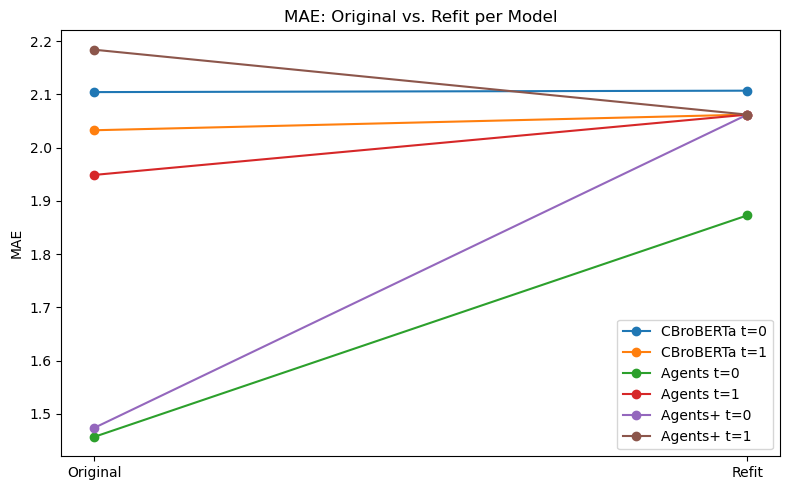

In [20]:
fig, ax = plt.subplots(figsize=(8,5))
models = compare_models_df['Model'].unique()
for model in models:
    orig_mae = compare_models_df[(compare_models_df['Model']==model) & (compare_models_df['Type']=='Original')]['MAE'].values
    refit_mae = compare_models_df[(compare_models_df['Model']==model) & (compare_models_df['Type']=='Refit')]['MAE'].values
    if len(orig_mae) and len(refit_mae):
        ax.plot([0, 1], [orig_mae[0], refit_mae[0]], marker='o', label=model)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Original', 'Refit'])
ax.set_ylabel('MAE')
ax.set_title('MAE: Original vs. Refit per Model')
ax.legend()
plt.tight_layout()
plt.show()


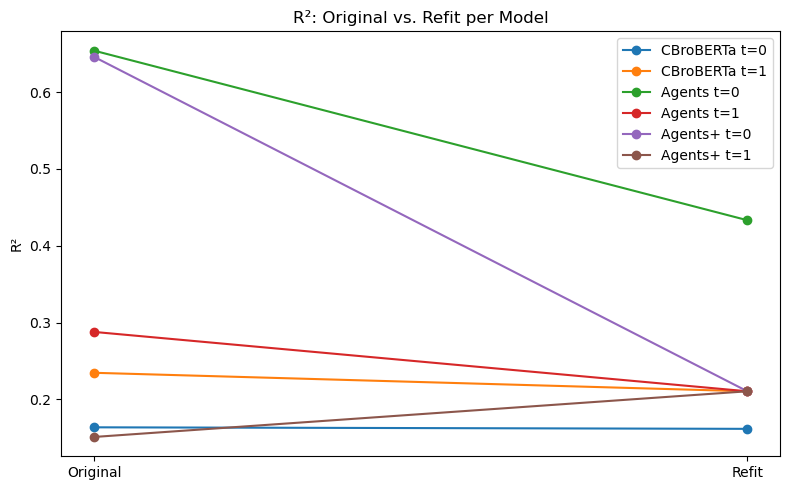

In [21]:
fig, ax = plt.subplots(figsize=(8,5))
models = compare_models_df['Model'].unique()
for model in models:
    orig_r2 = compare_models_df[(compare_models_df['Model']==model) & (compare_models_df['Type']=='Original')]['R2'].values
    refit_r2 = compare_models_df[(compare_models_df['Model']==model) & (compare_models_df['Type']=='Refit')]['R2'].values
    if len(orig_r2) and len(refit_r2):
        ax.plot([0, 1], [orig_r2[0], refit_r2[0]], marker='o', label=model)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Original', 'Refit'])
ax.set_ylabel('R²')
ax.set_title('R²: Original vs. Refit per Model')
ax.legend()
plt.tight_layout()
plt.show()


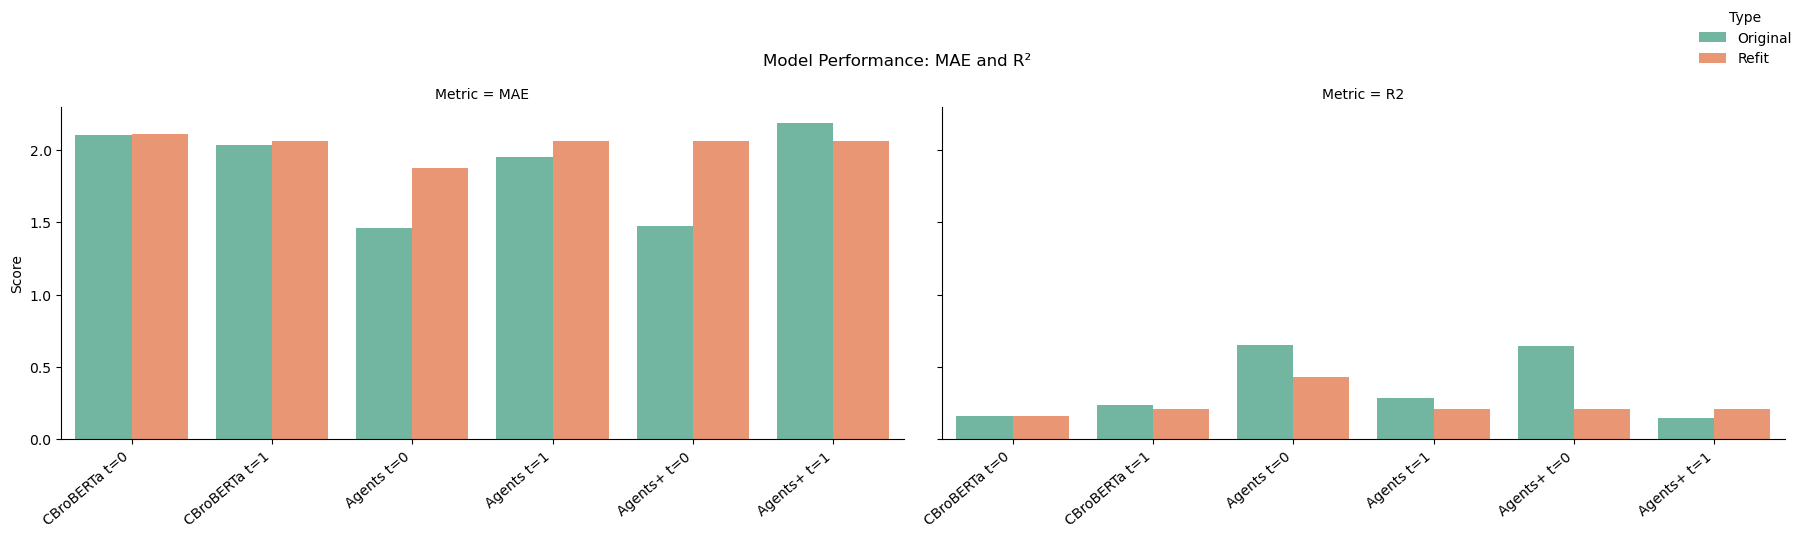

In [22]:
plot_df = compare_models_df.melt(
    id_vars=['Model', 'Type'],
    value_vars=['MAE', 'R2'],
    var_name='Metric',
    value_name='Value'
)

model_order = compare_models_df['Model'].unique()

g = sns.catplot(
    data=plot_df, kind='bar',
    x='Model', y='Value', hue='Type', col='Metric',
    order=model_order, palette="Set2",
    height=5, aspect=1.7, legend_out=True
)
g.set_xticklabels(rotation=40, ha='right')
g.set_axis_labels("", "Score")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Model Performance: MAE and R²')

# Remove any duplicated legends
if g._legend is not None:
    g._legend.set_bbox_to_anchor((1, 1))
    g._legend.set_title('Type')

plt.tight_layout()
plt.show()


#### Commentary 4

- Only Agents+ t=1 benefitted from refitting with statistically significant indicators in terms of increased R-squared and lower MAE.
- However, overall model Agents t=0 remains the best performing one.

In [23]:
# Find models (row indices) with highest R² and lowest MAE, before and after refit

# Highest R² before refit
idx_r2_orig = compare_models_df[(compare_models_df['Type']=='Original')]['R2'].idxmax()
# Highest R² after refit
idx_r2_refit = compare_models_df[(compare_models_df['Type']=='Refit')]['R2'].idxmax()

# Lowest MAE before refit
idx_mae_orig = compare_models_df[(compare_models_df['Type']=='Original')]['MAE'].idxmin()
# Lowest MAE after refit
idx_mae_refit = compare_models_df[(compare_models_df['Type']=='Refit')]['MAE'].idxmin()


In [24]:
def print_features_for_best(compare_models_df, idx, metric, stage):
    row = compare_models_df.loc[idx]
    print(f"\n--- {metric} ({stage}) ---")
    print(f"Model:    {row['Model']}")
    print(f"{metric}: {row[metric]:.3f}")
    print(f"Features: {row['Features']}\n")

# Features for highest R² before and after refit
print_features_for_best(compare_models_df, idx_r2_orig, 'R2', 'Original')
print_features_for_best(compare_models_df, idx_r2_refit, 'R2', 'Refit')

# Features for lowest MAE before and after refit
print_features_for_best(compare_models_df, idx_mae_orig, 'MAE', 'Original')
print_features_for_best(compare_models_df, idx_mae_refit, 'MAE', 'Refit')



--- R2 (Original) ---
Model:    Agents t=0
R2: 0.654
Features: ['firms', 'central_bank', 'households', 'cpi_rate_lag3', 'cpi_rate_lag4', 'cpi_rate_lag5', 'cpi_rate_lag6']


--- R2 (Refit) ---
Model:    Agents t=0
R2: 0.433
Features: ['central_bank', 'cpi_rate_lag6', 'cpi_rate_lag3', 'cpi_rate_lag4', 'cpi_rate_lag5', 'cpi_rate_lag6']


--- MAE (Original) ---
Model:    Agents t=0
MAE: 1.457
Features: ['firms', 'central_bank', 'households', 'cpi_rate_lag3', 'cpi_rate_lag4', 'cpi_rate_lag5', 'cpi_rate_lag6']


--- MAE (Refit) ---
Model:    Agents t=0
MAE: 1.873
Features: ['central_bank', 'cpi_rate_lag6', 'cpi_rate_lag3', 'cpi_rate_lag4', 'cpi_rate_lag5', 'cpi_rate_lag6']



In [25]:
top_models = pd.concat([
    compare_models_df.loc[[idx_r2_orig]],
    compare_models_df.loc[[idx_r2_refit]],
    compare_models_df.loc[[idx_mae_orig]],
    compare_models_df.loc[[idx_mae_refit]]
], axis=0)
top_models = top_models.drop_duplicates(subset=['Model', 'Type'])  # in case of ties

pd.set_option('display.max_colwidth', 500)
display(top_models[['Model','Type','MAE','R2','Features']])


,Model,Type,MAE,R2,Features
4,Agents t=0,Original,1.456678,0.653921,"[firms, central_bank, households, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"
5,Agents t=0,Refit,1.872746,0.433226,"[central_bank, cpi_rate_lag6, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]"


In [26]:
res_orig = res2_t0          # Original model fit result (SARIMAXResults)
res_refit = res2_t0_refit   # Refit model fit result


In [27]:
def residual_diagnostics(res, label="Model"):
    resid = res.resid
    fitted = res.fittedvalues
    fig, axes = plt.subplots(2, 3, figsize=(15,8))
    
    # 1. Residuals over time
    axes[0,0].plot(resid)
    axes[0,0].set_title(f'{label}: Residuals over Time')
    
    # 2. Residuals vs. Fitted
    axes[0,1].scatter(fitted, resid, alpha=0.6)
    axes[0,1].axhline(0, color='gray', linestyle='--')
    axes[0,1].set_title(f'{label}: Residuals vs. Fitted')
    
    # 3. Histogram
    sns.histplot(resid, kde=True, ax=axes[0,2])
    axes[0,2].set_title(f'{label}: Histogram of Residuals')
    
    # 4. Q-Q Plot
    stats.probplot(resid, dist="norm", plot=axes[1,0])
    axes[1,0].set_title(f'{label}: Q-Q Plot')
    
    # 5. ACF plot
    plot_acf(resid, ax=axes[1,1], lags=30, zero=False)
    axes[1,1].set_title(f'{label}: Residual ACF')
    
    # 6. PACF plot
    plot_pacf(resid, ax=axes[1,2], lags=30, zero=False, method='ywm')
    axes[1,2].set_title(f'{label}: Residual PACF')
    
    plt.tight_layout()
    plt.show()
    
    # 7. Ljung-Box test
    lb_test = acorr_ljungbox(resid, lags=[10], return_df=True)
    pval = lb_test['lb_pvalue'].iloc[0]
    print(f"{label} Ljung-Box test (lag=10): p-value = {pval:.4f}")
    if pval < 0.05:
        print("→ Residuals likely not independent (model may be missing structure).")
    else:
        print("→ Residuals appear independent (good).")


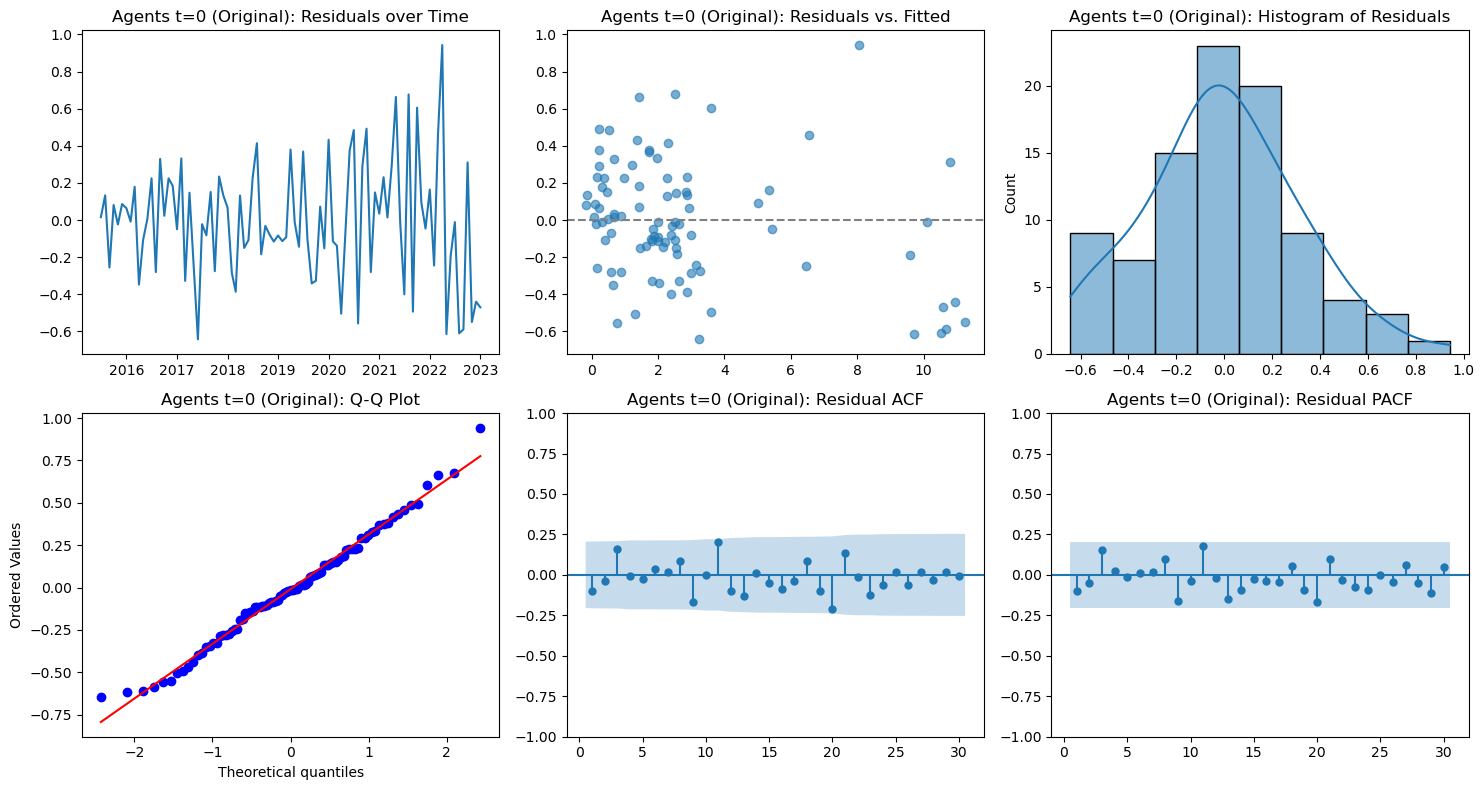

Agents t=0 (Original) Ljung-Box test (lag=10): p-value = 0.6801
→ Residuals appear independent (good).


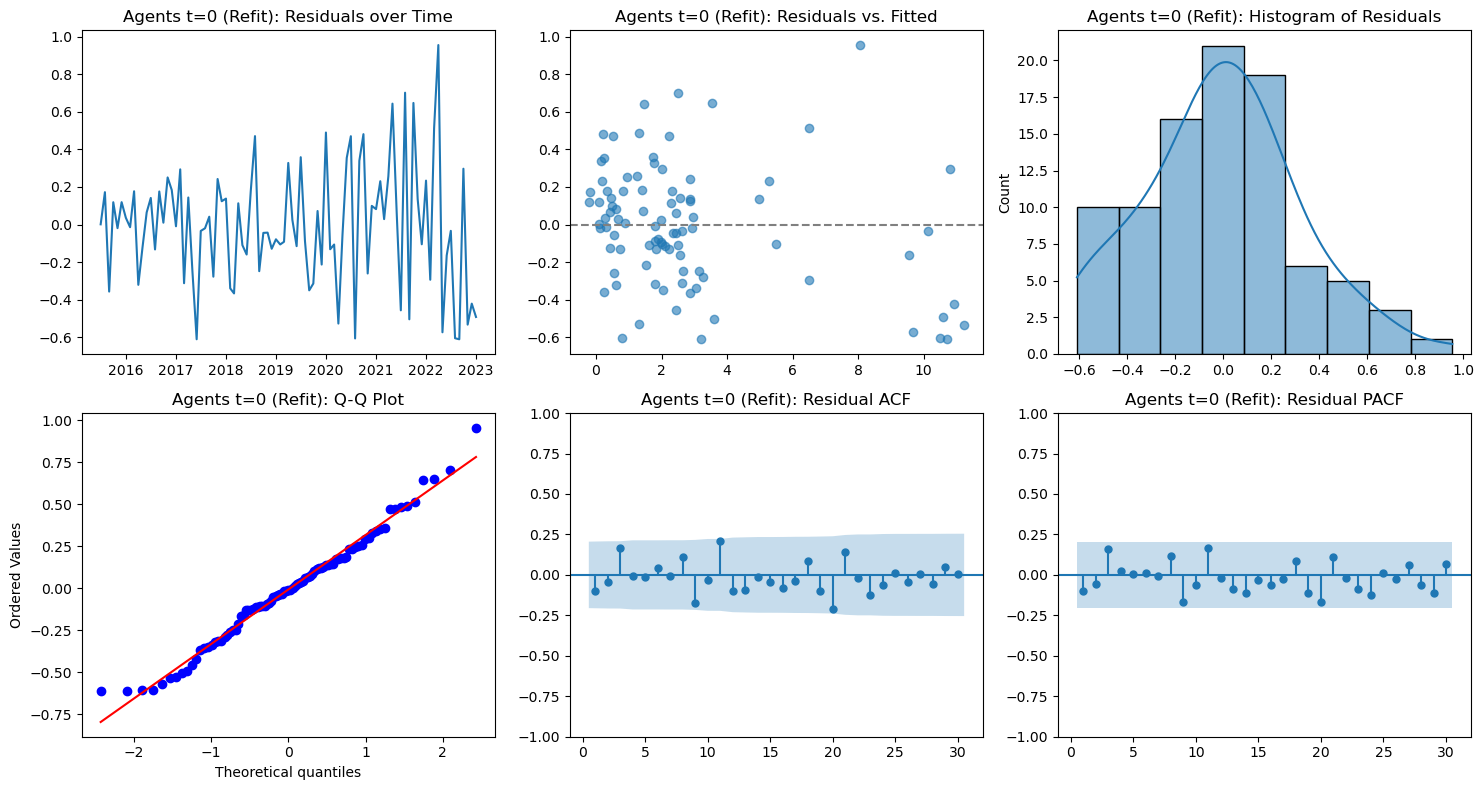

Agents t=0 (Refit) Ljung-Box test (lag=10): p-value = 0.5899
→ Residuals appear independent (good).


In [28]:
residual_diagnostics(res_orig, label="Agents t=0 (Original)")
residual_diagnostics(res_refit, label="Agents t=0 (Refit)")


#### Commentary 5

- Models for Agent t=0 (original and refit) errors are well-behaved, so statistical inference and forecasts are reliable.

## Section B

## Adding selected macro indicators to Model Agents t=0

### File import and lagged variables creation II

In [29]:
# 1. Load Data
df_tam1 = pd.read_csv("tsm_data_1.csv")
df_tam1['date'] = pd.to_datetime(df_tam1['date'])
df_tam1.set_index('date', inplace=True)
df_tam1 = df_tam1.asfreq('MS')

# 2. Create lag-1 variables for required columns
for var in ['gfk_cc', 'hpi_mom', 'infl_exp', 'wage_rate', 'unemp_rate']:
    df_tam1[f"{var}_lag1"] = df_tam1[var].shift(1)

# Create cpi_rate lags (3 to 6)
for lag in range(3, 7):
    df_tam1[f'cpi_rate_lag{lag}'] = df_tam1['cpi_rate'].shift(lag)

# 3. Define exogenous variables for Agents t=0 (Original)
exog_agents0_tam1 = [
    'firms', 'central_bank', 'households',
    'gfk_cc_lag1', 'hpi_mom_lag1', 'infl_exp_lag1', 'wage_rate_lag1', 'unemp_rate_lag1',
    'cpi_rate_lag3', 'cpi_rate_lag4', 'cpi_rate_lag5', 'cpi_rate_lag6'
]

df_tam1_model = df_tam1.dropna().copy()

# 4. Train/Test split
split_idx_tam1 = int(len(df_tam1_model) * 0.8)
train_tam1 = df_tam1_model.iloc[:split_idx_tam1]
test_tam1 = df_tam1_model.iloc[split_idx_tam1:]

# 5. Auto ARIMA order selection
auto_mod_tam1 = auto_arima(
    train_tam1['cpi_rate'],
    exogenous=train_tam1[exog_agents0_tam1],
    seasonal=True, m=12,
    trace=False, stepwise=True, error_action='ignore',
    suppress_warnings=True,
    max_p=3, max_q=3, max_P=2, max_Q=2, max_order=6,
    information_criterion='aic'
)
order_tam1, seas_order_tam1 = auto_mod_tam1.order, auto_mod_tam1.seasonal_order

# 6. Fit SARIMAX (Original model)
sarimax_agents0_tam1 = SARIMAX(
    train_tam1['cpi_rate'],
    exog=train_tam1[exog_agents0_tam1],
    order=order_tam1,
    seasonal_order=seas_order_tam1,
    enforce_stationarity=True,
    enforce_invertibility=True
)
fit_agents0_tam1 = sarimax_agents0_tam1.fit(disp=False)

# 7. Forecast (Original)
forecast_agents0_tam1 = fit_agents0_tam1.predict(start=test_tam1.index[0], end=test_tam1.index[-1], exog=test_tam1[exog_agents0_tam1])
mae_agents0_tam1 = mean_absolute_error(test_tam1['cpi_rate'], forecast_agents0_tam1)
r2_agents0_tam1 = r2_score(test_tam1['cpi_rate'], forecast_agents0_tam1)

# 8. Significant variables
sig_vars_agents0_tam1 = [var for var in exog_agents0_tam1 if fit_agents0_tam1.pvalues.get(var, 1) < 0.05]

# 9. Refit model with significant variables (if any)
if sig_vars_agents0_tam1:
    sarimax_agents0refit_tam1 = SARIMAX(
        train_tam1['cpi_rate'],
        exog=train_tam1[sig_vars_agents0_tam1],
        order=order_tam1,
        seasonal_order=seas_order_tam1,
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    fit_agents0refit_tam1 = sarimax_agents0refit_tam1.fit(disp=False)
    forecast_agents0refit_tam1 = fit_agents0refit_tam1.predict(
        start=test_tam1.index[0], end=test_tam1.index[-1], exog=test_tam1[sig_vars_agents0_tam1]
    )
    mae_agents0refit_tam1 = mean_absolute_error(test_tam1['cpi_rate'], forecast_agents0refit_tam1)
    r2_agents0refit_tam1 = r2_score(test_tam1['cpi_rate'], forecast_agents0refit_tam1)
else:
    mae_agents0refit_tam1, r2_agents0refit_tam1 = None, None

# 10. Comparison Table
comparison_tam1 = pd.DataFrame([
    {
        "Model": "Agents t=0",
        "Type": "Original",
        "MAE": mae_agents0_tam1,
        "R2": r2_agents0_tam1,
        "Features": exog_agents0_tam1
    },
    {
        "Model": "Agents t=0",
        "Type": "Refit",
        "MAE": mae_agents0refit_tam1,
        "R2": r2_agents0refit_tam1,
        "Features": sig_vars_agents0_tam1
    }
])
print(comparison_tam1)


        Model      Type       MAE        R2  \
0  Agents t=0  Original  2.000398  0.357449   
1  Agents t=0     Refit  2.141752  0.251959   

                                                                                                                                                                   Features  
0  [firms, central_bank, households, gfk_cc_lag1, hpi_mom_lag1, infl_exp_lag1, wage_rate_lag1, unemp_rate_lag1, cpi_rate_lag3, cpi_rate_lag4, cpi_rate_lag5, cpi_rate_lag6]  
1                                                                                                                              [central_bank, infl_exp_lag1, cpi_rate_lag6]  


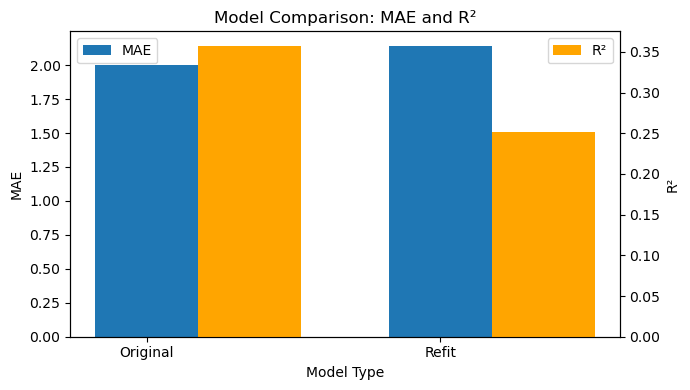

In [30]:
# Drop rows with None (if refit is not available)
plot_df = comparison_tam1.dropna(subset=['MAE', 'R2']).copy()

# Set positions
labels = plot_df['Type']
x = range(len(labels))

fig, ax1 = plt.subplots(figsize=(7, 4))

# Bar width
width = 0.35

# Plot MAE
mae_bar = ax1.bar(x, plot_df['MAE'], width, label='MAE')
ax1.set_ylabel('MAE')
ax1.set_xlabel('Model Type')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend(loc='upper left')

# Create a second y-axis for R2
ax2 = ax1.twinx()
r2_bar = ax2.bar([i + width for i in x], plot_df['R2'], width, color='orange', label='R²')
ax2.set_ylabel('R²')
ax2.legend(loc='upper right')

plt.title('Model Comparison: MAE and R²')
plt.tight_layout()
plt.show()


In [31]:
# Show which features were significant after refit
sig_df = pd.DataFrame({
    "Feature": exog_agents0_tam1,
    "Statistically Significant": ["✅" if f in sig_vars_agents0_tam1 else "" for f in exog_agents0_tam1]
})
print(sig_df)


            Feature Statistically Significant
0             firms                          
1      central_bank                         ✅
2        households                          
3       gfk_cc_lag1                          
4      hpi_mom_lag1                          
5     infl_exp_lag1                         ✅
6    wage_rate_lag1                          
7   unemp_rate_lag1                          
8     cpi_rate_lag3                          
9     cpi_rate_lag4                          
10    cpi_rate_lag5                          
11    cpi_rate_lag6                         ✅


In [32]:
print(fit_agents0_tam1.summary())


                                      SARIMAX Results                                      
Dep. Variable:                            cpi_rate   No. Observations:                   91
Model:             SARIMAX(1, 2, 2)x(2, 0, [], 12)   Log Likelihood                 -23.522
Date:                             Fri, 30 May 2025   AIC                             83.045
Time:                                     22:58:18   BIC                            127.840
Sample:                                 07-01-2015   HQIC                           101.100
                                      - 01-01-2023                                         
Covariance Type:                               opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
firms              -0.2703      0.199     -1.362      0.173      -0.659       0.119
central_bank

#### Commentary 6

- The addition of selected macro indicators deteriorates predictive power.
- Even with the addition of macro indicators, whilst refitting with only statistically significant predictors resulted in lower R-Squared and higher MAE, central_bank contemporaneous speech sentiment was one of the statistically significant variables. Others were infl_exp_lag1 (inflation expectations lagged by a month) and cpi_rate_lag6.
- Incuding longer lagged macro indicators is likely to masj the signal from speech sentiment.

*End of notebook*